In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path

# check if workding_dir is in local variables
if "workding_dir" not in locals():
    workding_dir = str(Path.cwd().parent)

os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

workding dir: /Users/inflaton/code/engd/papers/rapget-translation


In [3]:
from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=True)

loading env vars from: /Users/inflaton/code/engd/papers/rapget-translation/.env


True

In [4]:
import os

model_name = os.getenv("MODEL_NAME")
adapter_name_or_path = os.getenv("ADAPTER_NAME_OR_PATH")
load_in_4bit = os.getenv("LOAD_IN_4BIT") == "true"
data_path = os.getenv("DATA_PATH")
results_path = "results/mac-results_greedy_decoding.csv"  # os.getenv("RESULTS_PATH")
use_english_datasets = os.getenv("USE_ENGLISH_DATASETS") == "true"
max_new_tokens = int(os.getenv("MAX_NEW_TOKENS", 2048))

print(
    model_name,
    adapter_name_or_path,
    load_in_4bit,
    data_path,
    results_path,
    use_english_datasets,
    max_new_tokens,
)

01-ai/Yi-1.5-9B-Chat None False datasets/mac/mac.tsv results/mac-results_greedy_decoding.csv False 300


In [5]:
%%time
os.environ["TOKENIZERS_PARALLELISM"] = "true"

!python --version
!pip show torch transformers

Python 3.11.9
Name: torch
Version: 2.4.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /Users/inflaton/anaconda3/envs/rapget/lib/python3.11/site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: accelerate, peft, torchaudio, torchvision
---
Name: transformers
Version: 4.43.3
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /Users/inflaton/anaconda3/envs/rapget/lib/python3.11/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenize

In [6]:
from llm_toolkit.llm_utils import *
from llm_toolkit.translation_utils import *

device = check_gpu()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/inflaton/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/inflaton/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/inflaton/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


loading: /Users/inflaton/code/engd/papers/rapget-translation/eval_modules/calc_repetitions.py
loading /Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/inflaton/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/inflaton/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/inflaton/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


MPS is available


In [7]:
import pandas as pd

df = pd.read_csv(results_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1133 entries, 0 to 1132
Data columns (total 25 columns):
 #   Column                                           Non-Null Count  Dtype 
---  ------                                           --------------  ----- 
 0   chinese                                          1133 non-null   object
 1   english                                          1133 non-null   object
 2   Qwen/Qwen2-7B-Instruct/rpp-1.00                  1133 non-null   object
 3   Qwen/Qwen2-7B-Instruct/rpp-1.02                  1133 non-null   object
 4   Qwen/Qwen2-7B-Instruct/rpp-1.04                  1133 non-null   object
 5   Qwen/Qwen2-7B-Instruct/rpp-1.06                  1133 non-null   object
 6   Qwen/Qwen2-7B-Instruct/rpp-1.08                  1133 non-null   object
 7   Qwen/Qwen2-7B-Instruct/rpp-1.10                  1133 non-null   object
 8   Qwen/Qwen2-7B-Instruct/rpp-1.12                  1133 non-null   object
 9   Qwen/Qwen2-7B-Instruct/rpp-1.14          

In [8]:
result_columns = df.columns[2:].to_list()
result_columns.sort()
columns = df.columns[:2].to_list() + result_columns
result_columns, columns

(['Qwen/Qwen2-72B-Instruct/rpp-1.00',
  'Qwen/Qwen2-7B-Instruct/rpp-1.00',
  'Qwen/Qwen2-7B-Instruct/rpp-1.02',
  'Qwen/Qwen2-7B-Instruct/rpp-1.04',
  'Qwen/Qwen2-7B-Instruct/rpp-1.06',
  'Qwen/Qwen2-7B-Instruct/rpp-1.08',
  'Qwen/Qwen2-7B-Instruct/rpp-1.10',
  'Qwen/Qwen2-7B-Instruct/rpp-1.12',
  'Qwen/Qwen2-7B-Instruct/rpp-1.14',
  'Qwen/Qwen2-7B-Instruct/rpp-1.16',
  'Qwen/Qwen2-7B-Instruct/rpp-1.18',
  'Qwen/Qwen2-7B-Instruct/rpp-1.20',
  'Qwen/Qwen2-7B-Instruct/rpp-1.22',
  'Qwen/Qwen2-7B-Instruct/rpp-1.24',
  'Qwen/Qwen2-7B-Instruct/rpp-1.26',
  'Qwen/Qwen2-7B-Instruct/rpp-1.28',
  'Qwen/Qwen2-7B-Instruct/rpp-1.30',
  'internlm/internlm2_5-7b-chat-1m/rpp-1.00',
  'internlm/internlm2_5-7b-chat-1m/rpp-1.02',
  'shenzhi-wang/Llama3.1-70B-Chinese-Chat/rpp-1.00',
  'shenzhi-wang/Llama3.1-70B-Chinese-Chat/rpp-1.02',
  'shenzhi-wang/Llama3.1-70B-Chinese-Chat/rpp-1.04',
  'shenzhi-wang/Llama3.1-70B-Chinese-Chat/rpp-1.06'],
 ['chinese',
  'english',
  'Qwen/Qwen2-72B-Instruct/rpp-1.00',
 

In [9]:
df = df[columns]
metrics_df = get_metrics(df, max_output_tokens=max_new_tokens)
metrics_df

Qwen/Qwen2-72B-Instruct/rpp-1.00: {'meteor': 0.39496912014495184, 'bleu_scores': {'bleu': 0.12294894050451377, 'precisions': [0.42391407360606537, 0.1626695498329074, 0.079349416448331, 0.041761041902604754], 'brevity_penalty': 1.0, 'length_ratio': 1.048526001987413, 'translation_length': 31655, 'reference_length': 30190}, 'rouge_scores': {'rouge1': 0.4426680540635972, 'rouge2': 0.19155507784124037, 'rougeL': 0.38356294219564346, 'rougeLsum': 0.38422295991913064}, 'accuracy': 0.0, 'correct_ids': []}
Qwen/Qwen2-7B-Instruct/rpp-1.00: {'meteor': 0.3757937058055942, 'bleu_scores': {'bleu': 0.11257687997946404, 'precisions': [0.4221057489451477, 0.15152552819915763, 0.07046669041681511, 0.03563738956121464], 'brevity_penalty': 1.0, 'length_ratio': 1.004836038423319, 'translation_length': 30336, 'reference_length': 30190}, 'rouge_scores': {'rouge1': 0.42411379916904746, 'rouge2': 0.1742450243289532, 'rougeL': 0.36434769925835264, 'rougeLsum': 0.3646329060474352}, 'accuracy': 0.00088261253309

model   rpp    meteor    bleu_1  \
0                  Qwen/Qwen2-72B-Instruct  1.00  0.394969  0.122949   
1                   Qwen/Qwen2-7B-Instruct  1.00  0.375794  0.112577   
2                   Qwen/Qwen2-7B-Instruct  1.02  0.376816  0.115539   
3                   Qwen/Qwen2-7B-Instruct  1.04  0.371515  0.113116   
4                   Qwen/Qwen2-7B-Instruct  1.06  0.372161  0.109860   
5                   Qwen/Qwen2-7B-Instruct  1.08  0.371297  0.108095   
6                   Qwen/Qwen2-7B-Instruct  1.10  0.371353  0.108097   
7                   Qwen/Qwen2-7B-Instruct  1.12  0.368204  0.105056   
8                   Qwen/Qwen2-7B-Instruct  1.14  0.363077  0.100516   
9                   Qwen/Qwen2-7B-Instruct  1.16  0.360604  0.095724   
10                  Qwen/Qwen2-7B-Instruct  1.18  0.360785  0.095713   
11                  Qwen/Qwen2-7B-Instruct  1.20  0.356755  0.091249   
12                  Qwen/Qwen2-7B-Instruct  1.22  0.351004  0.083507   
13                  Qwen/Qwen2-7B-Instruct  1.24  0.346560  0.079543   
14                  Qwen/Qwen2-7B-Instruct  1.26  0.343517  0.078588   
15                  Qwen/Qwen2-7B-Instruct  1.28  0.340534  0.072038   
16                  Qwen/Qwen2-7B-Instruct  1.30  0.334469  0.062148   
17         internlm/internlm2_5-7b-chat-1m  1.00  0.371535  0.105977   
18         internlm/internlm2_5-7b-chat-1m  1.02  0.352901  0.086979   
19  shenzhi-wang/Llama3.1-70B-Chinese-Chat  1.00  0.381686  0.115183   
20  shenzhi-wang/Llama3.1-70B-Chinese-Chat  1.02  0.381085  0.114341   
21  shenzhi-wang/Llama3.1-70B-Chinese-Chat  1.04  0.380191  0.113532   
22  shenzhi-wang/Llama3.1-70B-Chinese-Chat  1.06  0.378622  0.112205   

     rouge_l  ews_score  repetition_score  total_repetitions       rap  \
0   0.383563   0.000000          0.171227           0.171227  0.392078   
1   0.364348   0.000000          0.092674           0.092674  0.374294   
2   0.369180   0.000000          0.086496           0.086496  0.375412   
3   0.363668   0.000000          0.092674           0.092674  0.370032   
4   0.360793   0.000000          0.101500           0.101500  0.370536   
5   0.359310   0.000000          0.047661           0.047661  0.370532   
6   0.359742   0.000000          0.082083           0.082083  0.370039   
7   0.358582   0.000000          0.220653           0.220653  0.364747   
8   0.349541   0.000000          0.109444           0.109444  0.361369   
9   0.350227   0.000000          0.101500           0.101500  0.359029   
10  0.344284   0.000000          0.079435           0.079435  0.359550   
11  0.344420   0.000000          0.110327           0.110327  0.355063   
12  0.336827   0.000000          0.089144           0.089144  0.349657   
13  0.333069   0.000000          0.074139           0.074139  0.345452   
14  0.330009   0.000000          0.112974           0.112974  0.341849   
15  0.325821   0.000000          0.111209           0.111209  0.338906   
16  0.322023   0.005296          0.142101           0.147396  0.332357   
17  0.362955   0.000000          5.531333           5.531333  0.311897   
18  0.340009   0.000000          0.124448           0.124448  0.351016   
19  0.370130   0.000000          0.195940           0.195940  0.378496   
20  0.369419   0.000000          0.210944           0.210944  0.377661   
21  0.369059   0.000000          0.201236           0.201236  0.376930   
22  0.368549   0.000000          0.201236           0.201236  0.375374   

    num_max_output_tokens  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0  
5                       0  
6                       0  
7                       0  
8                       0  
9                       1  
10                      0  
11                      1  
12                      0  
13                      0  
14                      1  
15                      2  
16                      6  
17                      1  

In [10]:
models = metrics_df["model"].unique()
models

array(['Qwen/Qwen2-72B-Instruct', 'Qwen/Qwen2-7B-Instruct',
       'internlm/internlm2_5-7b-chat-1m',
       'shenzhi-wang/Llama3.1-70B-Chinese-Chat'], dtype=object)

In [11]:
# list of markers for plotting
markers = [
    "o",
    "x",
    "^",
    "s",
    "d",
    "P",
    "X",
    "*",
    "v",
    ">",
    "<",
    "p",
    "h",
    "H",
    "+",
    "|",
    "_",
]
markers = {model: marker for model, marker in zip(models, markers)}

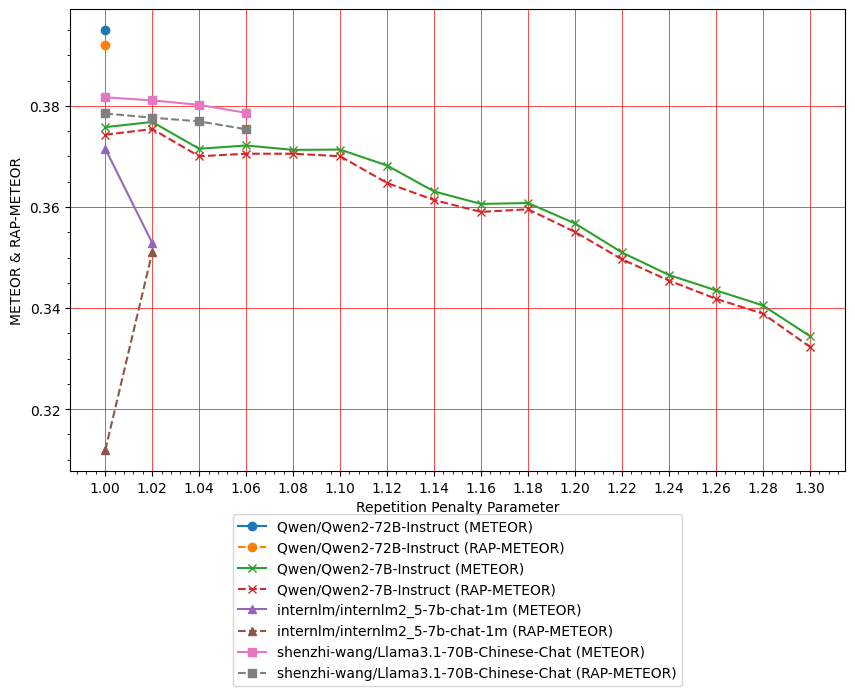

In [22]:
# plot meteor vs rpp
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
# set grid
ax.grid(True)
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(which="major", linestyle="-", linewidth="0.5", color="red")
# ax.grid(which="minor", linestyle=":", linewidth="0.5", color="black")

for model in models:
    model_df = metrics_df[metrics_df["model"] == model]
    ax.plot(
        model_df["rpp"],
        model_df["meteor"],
        label=model + " (METEOR)",
        marker=markers[model],
    )
    ax.plot(
        model_df["rpp"],
        model_df["rap"],
        label=model + " (RAP-METEOR)",
        linestyle="--",
        marker=markers[model],
    )

ax.set_xlabel("Repetition Penalty Parameter")
ax.set_ylabel("METEOR & RAP-METEOR")
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.48))
plt.show()

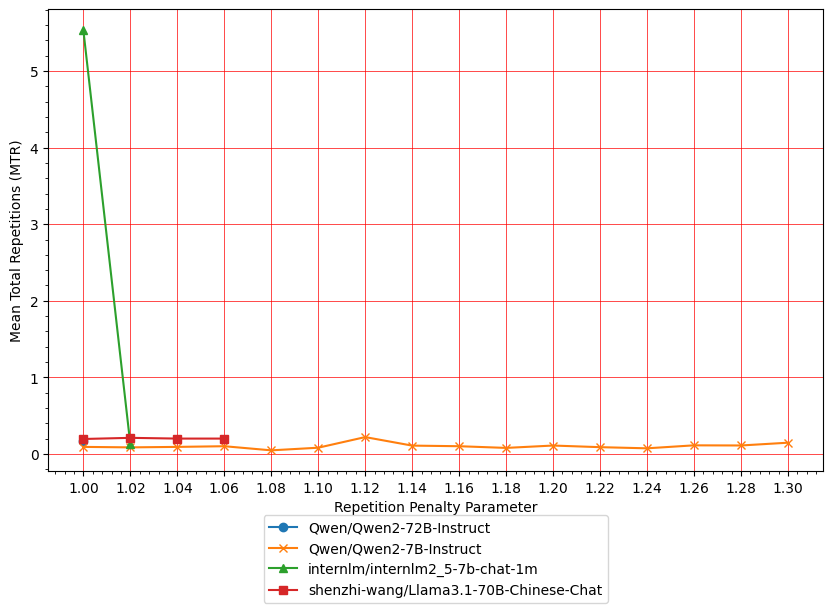

In [19]:
# plot mtr vs rpp
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
# set grid
ax.grid(True)
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(which="major", linestyle="-", linewidth="0.5", color="red")
# ax.grid(which="minor", linestyle=":", linewidth="0.5", color="black")

for model in models:
    model_df = metrics_df[metrics_df["model"] == model]
    ax.plot(
        model_df["rpp"],
        model_df["total_repetitions"],
        label=model,
        marker=markers[model],
    )

# ax.set_ylim(0, 1)
ax.set_xlabel("Repetition Penalty Parameter")
ax.set_ylabel("Mean Total Repetitions (MTR)")
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3))
plt.show()

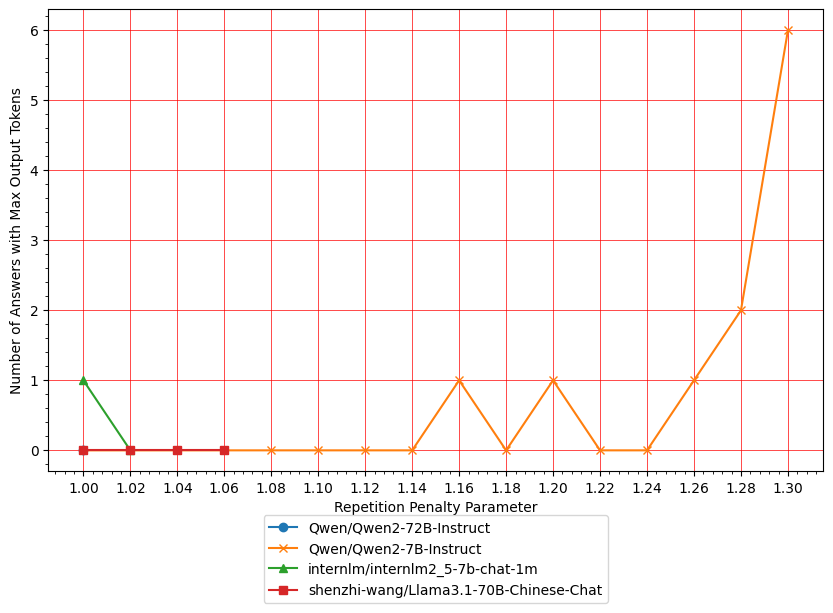

In [20]:
# plot mtr vs rpp
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
# set grid
ax.grid(True)
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(which="major", linestyle="-", linewidth="0.5", color="red")
# ax.grid(which="minor", linestyle=":", linewidth="0.5", color="black")

for model in models:
    model_df = metrics_df[metrics_df["model"] == model]
    ax.plot(
        model_df["rpp"],
        model_df["num_max_output_tokens"],
        label=model,
        marker=markers[model],
    )

# ax.set_ylim(0, 1)
ax.set_xlabel("Repetition Penalty Parameter")
ax.set_ylabel("Number of Answers with Max Output Tokens")
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3))
plt.show()

In [15]:
for col in result_columns:
    print(f"### Analyzing: {col}")
    analyze_translation_results(df, col)

### Analyzing: Qwen/Qwen2-72B-Instruct/rpp-1.00
*** Found 0 rows with total_repetitions > 100 for Qwen/Qwen2-72B-Instruct/rpp-1.00

*** Found 0 rows with output_tokens >= 300 for Qwen/Qwen2-72B-Instruct/rpp-1.00
### Analyzing: Qwen/Qwen2-7B-Instruct/rpp-1.00
*** Found 0 rows with total_repetitions > 100 for Qwen/Qwen2-7B-Instruct/rpp-1.00

*** Found 0 rows with output_tokens >= 300 for Qwen/Qwen2-7B-Instruct/rpp-1.00
### Analyzing: Qwen/Qwen2-7B-Instruct/rpp-1.02
*** Found 0 rows with total_repetitions > 100 for Qwen/Qwen2-7B-Instruct/rpp-1.02

*** Found 0 rows with output_tokens >= 300 for Qwen/Qwen2-7B-Instruct/rpp-1.02
### Analyzing: Qwen/Qwen2-7B-Instruct/rpp-1.04
*** Found 0 rows with total_repetitions > 100 for Qwen/Qwen2-7B-Instruct/rpp-1.04

*** Found 0 rows with output_tokens >= 300 for Qwen/Qwen2-7B-Instruct/rpp-1.04
### Analyzing: Qwen/Qwen2-7B-Instruct/rpp-1.06
*** Found 0 rows with total_repetitions > 100 for Qwen/Qwen2-7B-Instruct/rpp-1.06

*** Found 0 rows with output_to

In [16]:
metrics_df.to_csv(results_path.replace(".csv", "_metrics.csv"), index=False)

In [17]:
metrics_df.describe()

meteor     bleu_1    rouge_l  ews_score  repetition_score  \
count  23.000000  23.000000  23.000000  23.000000         23.000000   
mean    0.365454   0.100110   0.353719   0.000230          0.360451   
std     0.015245   0.016240   0.016500   0.001104          1.128318   
min     0.334469   0.062148   0.322023   0.000000          0.047661   
25%     0.354828   0.089114   0.342146   0.000000          0.090909   
50%     0.371297   0.105977   0.359310   0.000000          0.110327   
75%     0.376305   0.112846   0.366448   0.000000          0.183583   
max     0.394969   0.122949   0.383563   0.005296          5.531333   

       total_repetitions        rap  num_max_output_tokens  
count          23.000000  23.000000              23.000000  
mean            0.360682   0.360968               0.521739  
std             1.128272   0.018280               1.309739  
min             0.047661   0.311897               0.000000  
25%             0.090909   0.350336               0.000000  
50%             0.110327   0.364747               0.000000  
75%             0.183583   0.374834               0.500000  
max             5.531333   0.392078               6.000000